In [1]:
import time
import torch.optim as optim
import torch
# import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import math
import imf
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
from astropy.io import fits
from sklearn.ensemble import RandomForestRegressor
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def getmagerror(flux,eflux):
    return (-2.5*np.log10(flux-eflux)+2.5*np.log10(flux+eflux))/2
from sklearn import model_selection

import pandas as pd
import pickle
from isochrones import parsec
from isochrones.mist import MIST_Isochrone
from isochrones.parsec import Parsec_Isochrone
mist = Parsec_Isochrone()
#gforest,bpforest,rpforest,jforest,hforest,kforest,w1forest,w2forest,w3forest,w4forest,parallaxforest=pickle.load(open('errorforest.pickle', 'rb'))
clusterx ,clustery =pickle.load(open('ysotrainf1ms.pickle', 'rb'))
# clusterx1,clustery1=pickle.load(open('ysotrainf2ms.pickle', 'rb'))
# clusterx2,clustery2=pickle.load(open('ysotrainf3ms.pickle', 'rb'))


In [2]:
print(clustery.size())
# print(clustery1.size())
# print(clustery2.size())

torch.Size([87810, 6])


In [3]:
print(-2.5*np.log10(10**(-mist.mag['G'](mass, 8, feh, distance, AV)/2.5)))
print(-2.5*np.log10(10**(-mist.mag['G'](mass, 8.3, feh, distance, AV)/2.5)))
print(-2.5*np.log10(10**(-mist.mag['G'](mass, 7.5, feh, distance, AV)/2.5)))

NameError: name 'mass' is not defined

In [6]:
size=300000
mass = np.random.uniform(low=0.08,high=3,size=size)
age=np.random.uniform(low=6,high=10,size=size)
feh=np.random.uniform(low=-2.5,high=0.5,size=size)
distance=np.random.uniform(low=50,high=1000,size=size)
AV=np.random.uniform(low=0,high=20,size=size)
clx = np.recarray(size,dtype=[('g', float), ('bp', float),('rp', float),('j', float), ('h', float),('k', float), ('w1', float),('w2', float), ('w3', float),('parallax', float),('mass', float),('massratio', float),('age', float),('feh', float),('av', float),('teff', float),('logg', float),('distance', float),('logl', float),('radius', float)])
clx.mass=mass
clx.age=age
clx.feh=feh
clx.av=AV

clx.g=-2.5*np.log10(10**(-mist.mag['G'](mass, age, feh, distance, AV)/2.5))
#test=-2.5*np.log10(10**(-mist.mag['G'](mass, 8, feh, distance, AV)/2.5))
clx.bp=-2.5*np.log10(10**(-mist.mag['BP'](mass, age, feh, distance, AV)/2.5))
clx.rp=-2.5*np.log10(10**(-mist.mag['RP'](mass, age, feh, distance, AV)/2.5))
clx.j=-2.5*np.log10(10**(-mist.mag['J'](mass, age, feh, distance, AV)/2.5))
clx.h=-2.5*np.log10(10**(-mist.mag['H'](mass, age, feh, distance, AV)/2.5))
clx.k=-2.5*np.log10(10**(-mist.mag['K'](mass, age, feh, distance, AV)/2.5))
clx.w1=-2.5*np.log10(10**(-mist.mag['W1'](mass, age, feh, distance, AV)/2.5))
clx.w2=-2.5*np.log10(10**(-mist.mag['W2'](mass, age, feh, distance, AV)/2.5))
clx.w3=-2.5*np.log10(10**(-mist.mag['W3'](mass, age, feh, distance, AV)/2.5))
clx.teff=mist.Teff(mass, age, feh)
clx.logg=mist.logg(mass, age, feh)
clx.logl=mist.logL(mass, age, feh)
clx.radius=mist.radius(mass, age, feh)
clx.parallax=1000/distance
clx.distance=distance
#x=np.where(np.abs(clx.g-test)<0.05)[0]
#clx.age[x]=8


clx=clx[np.where((np.isfinite(clx.g)==True) & (np.isfinite(clx.teff)==True) & np.isfinite(clx.logg)==True)[0]]

#clx.g=clx.g+np.random.normal(size=len(clx))*gforest.predict(np.nan_to_num(clx.g).reshape(-1, 1))
#clx.bp=clx.bp+np.random.normal(size=len(clx))*bpforest.predict(np.nan_to_num(clx.bp).reshape(-1, 1))
#clx.rp=clx.rp+np.random.normal(size=len(clx))*rpforest.predict(np.nan_to_num(clx.rp).reshape(-1, 1))
#clx.j=clx.j+np.random.normal(size=len(clx))*jforest.predict(np.nan_to_num(clx.j).reshape(-1, 1))
#clx.h=clx.h+np.random.normal(size=len(clx))*hforest.predict(np.nan_to_num(clx.h).reshape(-1, 1))
#clx.k=clx.k+np.random.normal(size=len(clx))*kforest.predict(np.nan_to_num(clx.k).reshape(-1, 1))
#clx['w1'][np.where(clx.w1>17)[0]]=float('NaN')
#clx.w1=clx.w1+np.random.normal(size=len(clx))*w1forest.predict(np.nan_to_num(clx.w1).reshape(-1, 1))
#clx.w2=clx.w2+np.random.normal(size=len(clx))*w2forest.predict(np.nan_to_num(clx.w2).reshape(-1, 1))
#clx.w3=clx.w3+np.random.normal(size=len(clx))*w3forest.predict(np.nan_to_num(clx.w3).reshape(-1, 1))
#clx.parallax=clx.parallax+np.random.normal(size=len(clx))*parallaxforest.predict(np.nan_to_num([clx.g,clx.parallax]).T)

clx['g'][np.where(clx.g>19)[0]]=float('NaN')
clx['bp'][np.where(clx.bp>20.5)[0]]=float('NaN')
clx['rp'][np.where(clx.rp>17.5)[0]]=float('NaN')
clx['j'][np.where(clx.j>17)[0]]=float('NaN')
clx['h'][np.where(clx.h>16)[0]]=float('NaN')
clx['k'][np.where(clx.k>16)[0]]=float('NaN')
clx['w1'][np.where(clx.w1>16)[0]]=float('NaN')
clx['w2'][np.where(clx.w2>16)[0]]=float('NaN')
clx['w3'][np.where(clx.w3>13.5)[0]]=float('NaN')
clx=clx[np.where(np.isfinite(clx.g)==True)[0]]
clx['bp'][np.where(np.isfinite(clx.bp)==False)[0]]=21
clx['rp'][np.where(np.isfinite(clx.rp)==False)[0]]=18
clx['j'][np.where(np.isfinite(clx.j)==False)[0]]=17.5
clx['h'][np.where(np.isfinite(clx.h)==False)[0]]=16.5
clx['k'][np.where(np.isfinite(clx.k)==False)[0]]=16.5
clx['w1'][np.where(np.isfinite(clx.w1)==False)[0]]=16.5
clx['w2'][np.where(np.isfinite(clx.w2)==False)[0]]=16.5
clx['w3'][np.where(np.isfinite(clx.w3)==False)[0]]=14
clx['radius'][np.where(clx.radius<0.5)[0]]=0.5
clx['logl'][np.where(clx.logl<-1.54)[0]]=-1.54
k=np.where(clx.g-5*(np.log10(1000/clx.parallax)-1)>10)[0]
clx['radius'][k]=0.5
clx['logl'][k]=-1.54
size=len(clx)

clusterx=torch.Tensor (size, 1,12)
clustery=torch.Tensor(size,6)
for a in range(size):
    clusterx[a][0][0]=0.5
    clusterx[a][0][1]=0.5
    clusterx[a][0][2]=0.5
    clusterx[a][0][3]=0.5
    clusterx[a][0][4]=0.5
    clusterx[a][0][5]=0.5
    clusterx[a][0][6]=0.5
    clusterx[a][0][7]=0.5
    clusterx[a][0][8]=0.5
    clusterx[a][0][9]=0.5
    
    clusterx[a][0][0]=clx['g'][a]/21-0.5
    clusterx[a][0][1]=clx['bp'][a]/21-0.5
    clusterx[a][0][2]=clx['rp'][a]/18-0.5
    clusterx[a][0][3]=clx['j'][a]/17.5-0.5
    clusterx[a][0][4]=clx['h'][a]/16.5-0.5
    clusterx[a][0][5]=clx['k'][a]/16.5-0.5
    clusterx[a][0][6]=clx['w1'][a]/16.5-0.5
    clusterx[a][0][7]=clx['w2'][a]/16.5-0.5
    clusterx[a][0][8]=clx['w3'][a]/14-0.5
    clusterx[a][0][9]=clx['parallax'][a]/20-0.5
    clusterx[a][0][10]=(clx.radius[a]-0.2)/5-0.5
    clusterx[a][0][11]=clx.logl[a]/4
    clustery[a][0]=(clx.age[a]-6)/2-0.5
    clustery[a][1]=clx.av[a]/20-0.5
    clustery[a][2]=clx.mass[a]/3-0.5
    clustery[a][3]=(np.log10(clx.teff[a])-3.4)/0.7-0.5
    clustery[a][4]=(clx.logg[a]-3)/2-0.5
    clustery[a][5]=(clx.feh[a]+2.5)/3-0.5
pickle.dump([clusterx,clustery],open('ysotrainf1ms.pickle', 'wb'))

In [2]:
class Net(nn.Module):
    def __init__(self, input_shape=(1, 12)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3,padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3,padding=1)
        self.conv3 = nn.Conv1d(16, 32, 3,padding=1)
        n_size = self._get_conv_output(input_shape)
        print(n_size)
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 6)

    # generate input sample and forward to get shape
    def _get_conv_output(self, shape):
        bs = 1
        input = (torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = F.max_pool1d(F.relu(self.conv2(F.relu(self.conv1(x)))), 2)
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        #x = F.relu(F.max_pool2d(self.conv4(x), 2))
        #x = F.max_pool2d(F.relu(self.conv4(F.relu(self.conv3(x)))), 2)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
BAD_LOSS = 100000000
model = Net()
device = torch.device("cpu")
model=model.to(device)
#model=nn.parallel.DistributedDataParallelCPU(model)

inputs = clusterx
target = clustery
#model.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

# train
best_loss = BAD_LOSS
running_dev_loss = 0
badcount = 0
t = time.time()
n=0

a=torch.rand(23500,1,12)
print(clusterx.size())
print(a.size())
print(model(clusterx))

96
torch.Size([88089, 1, 12])
torch.Size([23500, 1, 12])
tensor([[-0.0049,  0.0345, -0.0201,  0.0047,  0.0436,  0.0293],
        [-0.0052,  0.0335, -0.0185,  0.0028,  0.0434,  0.0290],
        [-0.0046,  0.0355, -0.0204,  0.0046,  0.0427,  0.0293],
        ...,
        [-0.0054,  0.0336, -0.0193,  0.0043,  0.0437,  0.0295],
        [-0.0047,  0.0359, -0.0209,  0.0053,  0.0430,  0.0290],
        [-0.0058,  0.0348, -0.0197,  0.0054,  0.0436,  0.0296]],
       grad_fn=<AddmmBackward>)


In [105]:
clusterx.requires_grad=True
clustery.requires_grad=True
#criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
#torch.set_num_threads(7)
start_time=time.time()
model.train()

ran=range(85000)

for epoch in range(100000):  # loop over the dataset multiple times
    model.train()
    t = time.time()
    k=random.sample(ran, len(ran))
    running_loss=0
    for i in range(850):
        inputs=clusterx[k[i*100:(i+1)*100]]
        target=clustery[k[i*100:(i+1)*100]]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        getloss = loss.item()
        running_loss=getloss+running_loss

    n=n+1
    if n % 1 == 0:
        model.eval()
        optimizer.zero_grad()
        with torch.no_grad():
            dev_outputs = model.forward(clusterx1)
            dev_loss = criterion(dev_outputs, clustery1)
        print( (n, time.time()-t,running_loss,dev_loss.item()))
print('Finished Training')
print("Best dev loss=%.5f" % running_loss)
print("Total run time in minutes=%.2f" % ((time.time() - start_time) / 60))
torch.save(model.state_dict(), 'modelfullparsec2.pt')

(620, 6.47121524810791, 10287.762558937073, 10850.814453125)
(621, 6.4429240226745605, 10313.848776817322, 11030.7177734375)
(622, 6.297539949417114, 10343.426208019257, 11152.87890625)
(623, 6.231440782546997, 10293.345306396484, 13008.025390625)
(624, 6.266784906387329, 10342.37289428711, 11338.7626953125)
(625, 6.327581882476807, 10301.643104076385, 10973.4501953125)
(626, 6.32887601852417, 10291.875998973846, 11129.9306640625)
(627, 6.413216829299927, 10268.75506734848, 10966.44140625)
(628, 6.296170949935913, 10262.060028076172, 11237.1123046875)
(629, 6.33151912689209, 10345.536241054535, 11226.8564453125)
(630, 6.293248176574707, 10331.98651266098, 11023.03515625)
(631, 6.332932949066162, 10381.555607795715, 11253.7490234375)
(632, 6.31450629234314, 10325.04881811142, 10839.517578125)
(633, 6.3260719776153564, 10307.228917598724, 10900.5654296875)
(634, 6.379885196685791, 10223.801677703857, 10980.0810546875)
(635, 6.300701141357422, 10306.8560962677, 11493.150390625)
(636, 6.29

KeyboardInterrupt: 

16423


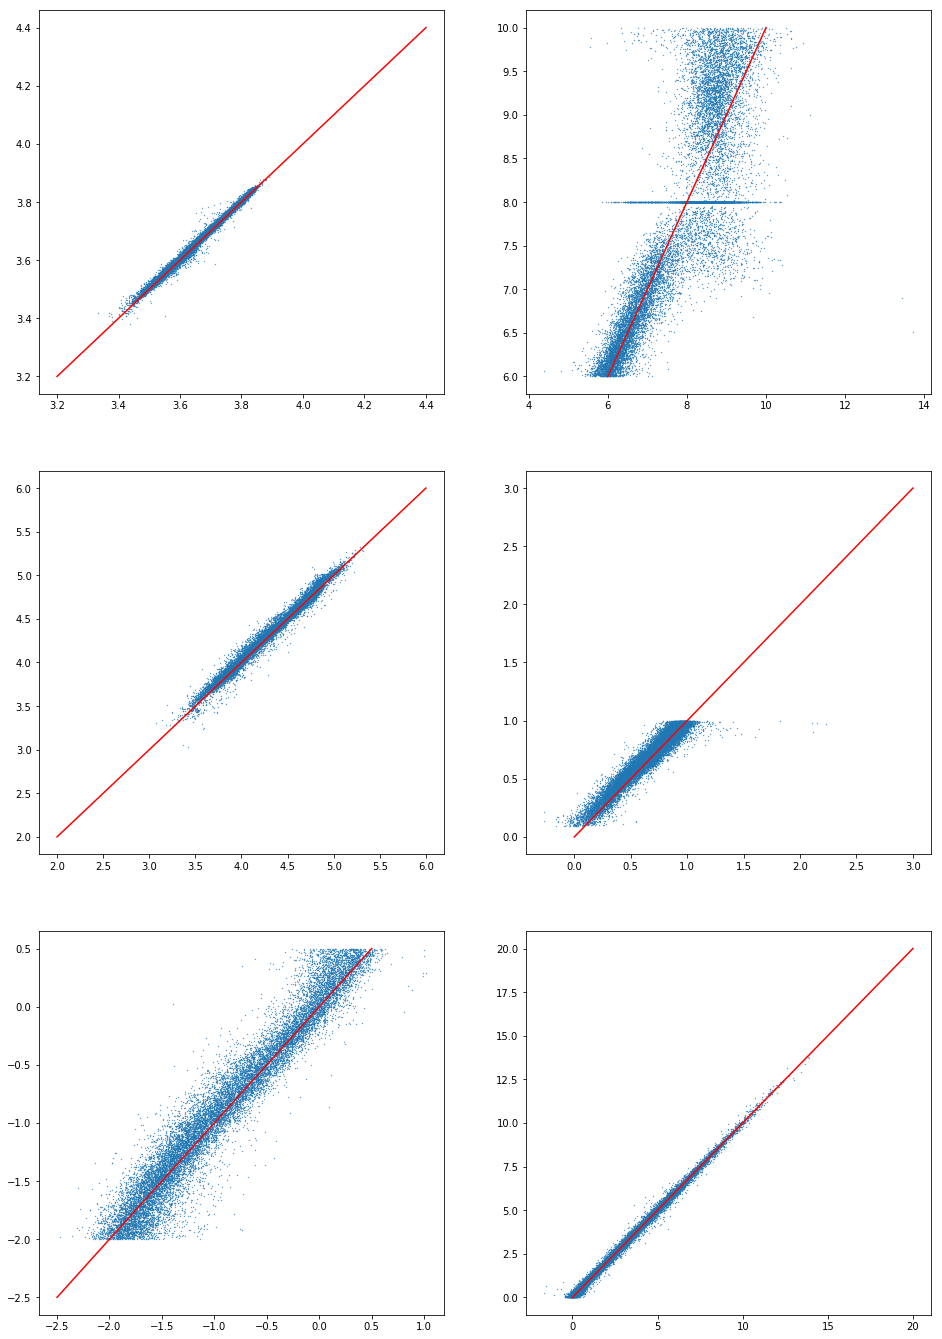

In [108]:
model.eval()
a=model(clusterx2)
result2=pd.DataFrame(a.detach().numpy(),columns=['age','av','mass','teff','logg','feh'])
result2['age']=(result2['age']+0.5)*2+6
result2['mass']=(result2['mass']+0.5)*3
result2['av']=(result2['av']+0.5)*20
result2['logg']=(result2['logg']+0.5)*2+3
result2['feh']=(result2['feh']+0.5)*3-2.5
result2['teff']=(result2['teff']+0.5)*0.7+3.4
compare2=pd.DataFrame(clustery2.numpy(),columns=['age','av','mass','teff','logg','feh'])
compare2['age']=(compare2['age']+0.5)*2+6
compare2['mass']=(compare2['mass']+0.5)*3
compare2['av']=(compare2['av']+0.5)*20
compare2['logg']=(compare2['logg']+0.5)*2+3
compare2['feh']=(compare2['feh']+0.5)*3-2.5
compare2['teff']=(compare2['teff']+0.5)*0.7+3.4
a=np.where((compare2['mass']<1) & (compare2['age']<70))[0]
print(len(a))
import matplotlib.pyplot as plt
f, ax =plt.subplots(3,2,figsize=(16,24))
ax[0, 0].scatter((result2['teff'][a]),(compare2['teff'][a]),s=0.1)
ax[0, 0].plot([3.2,4.4],[3.2,4.4],c='r')
ax[0, 1].scatter((result2['age'][a]),(compare2['age'][a]),s=0.1)
ax[0, 1].plot([6,10],[6,10],c='r')
ax[1, 0].scatter((result2['logg'][a]),(compare2['logg'][a]),s=0.1)
ax[1, 0].plot([2,6],[2,6],c='r')
#plt.show()
ax[1, 1].scatter((result2['mass'][a]),(compare2['mass'][a]),s=0.1)
ax[1, 1].plot([0,3],[0,3],c='r')
ax[2, 0].scatter((result2['feh'][a]),(compare2['feh'][a]),s=0.1)
ax[2, 0].plot([-2.5,0.5],[-2.5,0.5],c='r')
ax[2, 1].scatter((result2['av'][a]),(compare2['av'][a]),s=0.1)
ax[2, 1].plot([0,20],[0,20],c='r')
#ax[2, 1].plot([-0.5,0.5],[-0.5,0.5],c='r')
plt.show()

#    clustery[a][3]=(np.log10(clx.teff[a])-3.4)/0.7-0.5
#    clustery[a][4]=(clx.logg[a]-3)/2-0.5

In [30]:
print(np.max(compare2['age']))

1.4995397


In [66]:
d=fits.open('oriall.fits')
data1=d[1].data
d.close()
data1['phot_bp_mean_mag'][np.where(np.isnan(data1['phot_bp_mean_mag']))[0]]=21
data1['phot_rp_mean_mag'][np.where(np.isnan(data1['phot_rp_mean_mag']))[0]]=18
data1['j_m'][np.where(np.isnan(data1['j_m']))[0]]=17.5
data1['h_m'][np.where(np.isnan(data1['h_m']))[0]]=16.5
data1['ks_m'][np.where(np.isnan(data1['ks_m']))[0]]=16.5
data1['w1mpro'][np.where(np.isnan(data1['w1mpro']))[0]]=16.5
data1['w2mpro'][np.where(np.isnan(data1['w2mpro']))[0]]=16.5
data1['w3mpro'][np.where(np.isnan(data1['w3mpro']))[0]]=14
data1['radius_val'][np.where(np.isnan(data1['radius_val']))[0]]=0.5
data1['lum_val'][np.where(np.isnan(data1['lum_val']))[0]]=10**(-1.54)
k=np.where(data1['phot_g_mean_mag']-5*(np.log10(1000/data1['parallax']-1))>10)[0]
data1['radius_val'][k]=0.5
data1['lum_val'][k]=10**(-1.54)


datax=torch.Tensor (len(data1['phot_g_mean_mag']), 1,12)

for a in range(len(data1['phot_g_mean_mag'])):
    
    datax[a][0][0]=0.5
    datax[a][0][1]=0.5
    datax[a][0][2]=0.5
    datax[a][0][3]=0.5
    datax[a][0][4]=0.5
    datax[a][0][5]=0.5
    datax[a][0][6]=0.5
    datax[a][0][7]=0.5
    datax[a][0][8]=0.5
    datax[a][0][9]=0.5
    
    datax[a][0][0]=data1['phot_g_mean_mag'][a]/21-0.5
    datax[a][0][1]=data1['phot_bp_mean_mag'][a]/21-0.5
    datax[a][0][2]=data1['phot_rp_mean_mag'][a]/18-0.5
    datax[a][0][3]=data1['j_m'][a]/17.5-0.5
    datax[a][0][4]=data1['h_m'][a]/16.5-0.5
    datax[a][0][5]=data1['ks_m'][a]/16.5-0.5
    datax[a][0][6]=data1['w1mpro'][a]/16.5-0.5
    datax[a][0][7]=data1['w2mpro'][a]/16.5-0.5
    datax[a][0][8]=data1['w3mpro'][a]/14-0.5
    datax[a][0][9]=data1['parallax'][a]/20-0.5
    datax[a][0][10]=(data1['radius_val'][a]-0.2)/5-0.5
    datax[a][0][11]=np.log10(data1['lum_val'][a])/4
#datax=datax[k]

#pickle.dump([clusterx,clustery],open('datax.pickle', 'wb'))
a=model(datax)
result=pd.DataFrame(a.detach().numpy(),columns=['age','av','mass','teff','logg','feh'])

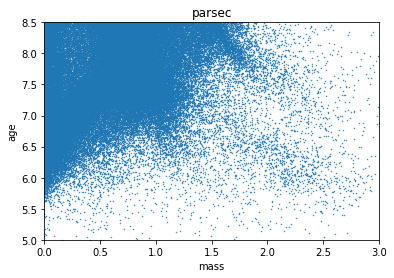

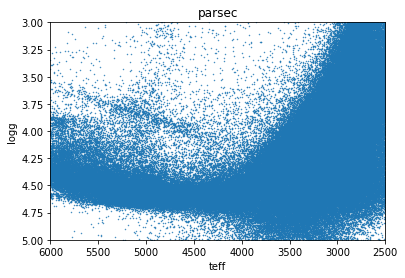

5005560


In [67]:
#    clustery[a][0]=(clx.age[a]-6)/2-0.5
#    clustery[a][1]=clx.av[a]/20-0.5
#    clustery[a][2]=clx.mass[a]/3-0.5
#    clustery[a][3]=(np.log10(clx.teff[a])-3.4)/0.7-0.5
#    clustery[a][4]=(clx.logg[a]-3)/2-0.5
plt.scatter((result.mass+0.5)*3,(result.age+0.5)*2+6,s=0.2)
plt.xlim(0,3)
plt.ylim(5,8.5)
plt.xlabel('mass')
plt.ylabel('age')
plt.title('parsec')
plt.show()
plt.scatter(10**((result.teff+0.5)*0.7+3.4),(result.logg+0.5)*2+3,s=0.2)
plt.xlim(6000,2500)
plt.ylim(5,3)
plt.xlabel('teff')
plt.ylabel('logg')
plt.title('parsec')
plt.show()
#plt.scatter(10**((result.teff+0.5)*0.7+3.4),data['teff_val'],s=0.1)
#plt.show()
print(len(result.av+0.5)*20)
result.teff=10**((result.teff+0.5)*0.7+3.4)
result.logg=(result.logg+0.5)*2+3
result.mass=(result.mass+0.5)*3
result.age=(result.age+0.5)*2+6
result.av=(result.av+0.5)*2
result['feh']=(result['feh']+0.5)*3-2.5
result.to_csv('oriall2.csv',index=True)

In [3]:
model = Net()
model.load_state_dict(torch.load('modelfullparsec2.pt'))
model.eval()

96


Net(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=96, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=5, bias=True)
)